# Image Classification with Transfer Learning

The goal of this section is to demonstrate key techniques for improving performance when working with convolutional neural networks under a transfer learning approach, which is a widely recommended practice (Goodfellow et al., 2016; Géron, 2022). To achieve this, I chose to work with the `MobileNet` and `NASNetMobile` architectures, as they offer the fastest inference times among the models available in `Keras` for transfer learning.

However, `MobileNet`, which has the fastest inference time, does not support 32 × 32 images for transfer learning. Therefore, when applying transfer learning, I used `NASNetMobile` instead.

If the primary objective were to maximize model accuracy, larger architectures like `NASNetLarge` would be preferable, as performance on ImageNet is positively correlated with performance on other datasets when using transfer learning (Kornblith et al., 2019). Another option would be to use `AutoGluon's AutoMM` (see my notebook [here](https://github.com/alexhubbe/image_classification/blob/main/notebooks/02_ah_autogluon.ipynb)). Additional alternatives can also be found [here](https://paperswithcode.com/sota/image-classification-on-cifar-10).

# Table of Contents
1. [Packages and Data Importation](#Packages-and-Data-Importation)  
2. [Data Sanity Check](#Data-Sanity-Check)
3. [Creating a Figure to Illustrate the Pictures within Each Class](#Creating-a-Figure-to-Illustrate-the-Pictures-within-Each-Class)
4. [Models](#Models)
    1. [MobileNet Model I](#MobileNet-Model-I)
    2. [MobileNet Model II.1](#MobileNet-Model-II.1)
    3. [MobileNet Model II.2](#MobileNet-Model-II.2)
    4. [MobileNet Model II.3](#MobileNet-Model-II.3)
    5. [MobileNet Model II.4](#MobileNet-Model-II.4)
    6. [MobileNet Model II.5](#MobileNet-Model-II.5)
    7. [NASNetMobile Model I](#NASNetMobile-Model-I)
    8. [NASNetMobile Model II](#NASNetMobile-Model-II)
    9. [NASNetMobile Model III](#NASNetMobile-Model-III)
5. [References](#References)

# Packages and Data Importation

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #reduce the warnings from tensorflow

import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.mobilenet import preprocess_input

from tensorflow.keras.applications import MobileNet

from tensorflow.keras.applications import NASNetMobile

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.keras.regularizers import l2

from src.config import (
    BETTERFIT_FIG,
    KT_TUNER_DIRECTORY,
    KT_TUNER_PROJECT_NAME,
    MODELCHECKPOINT,
    RANDOM_STATE,
    README_INTRO_FIG,
    OVERFIT_FIG,
)

## Fixed Hyperparameters in the Models

In [34]:
EPOCHS = 30
BATCH_SIZE = 128

## Data Importation

In [15]:
# Import data
cifar10 = keras.datasets.cifar10

In [17]:
#load the predefined train and test datasets
(X_train, y_train), (X_test,y_test) = cifar10.load_data()

#to ensure that the input data is formatted and normalized in the same way as the data used to train the ResNet model on the ImageNet dataset

X_train_mobilenet = keras.applications.mobilenet.preprocess_input(X_train)
X_test_mobilenet = keras.applications.mobilenet.preprocess_input(X_test)


X_train_nasnet = keras.applications.nasnet.preprocess_input(X_train)
X_test_nasnet = keras.applications.nasnet.preprocess_input(X_test)


# Data Sanity Check

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)

Absolute frequency per class in train dataset:
((0, 5000), (1, 5000), (2, 5000), (3, 5000), (4, 5000), (5, 5000), (6, 5000), (7, 5000), (8, 5000), (9, 5000))
Absolute frequency per class in test dataset:
((0, 1000), (1, 1000), (2, 1000), (3, 1000), (4, 1000), (5, 1000), (6, 1000), (7, 1000), (8, 1000), (9, 1000))

X_train maximum and minimum values: 255 and 0
X_test maximum and minimum values: 255 and 0

y_train is randomly distributed:


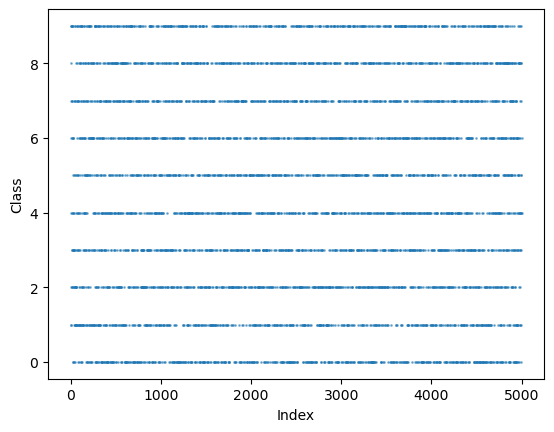

In [16]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')
print()

count = tuple(zip(*np.unique(y_train, return_counts=True)))
clean_count = tuple((int(label), int(count)) for label, count in count)

print(f'Absolute frequency per class in train dataset:\n{clean_count}')

count = tuple(zip(*np.unique(y_test, return_counts=True)))
clean_count = tuple((int(label), int(count)) for label, count in count)

print(f'Absolute frequency per class in test dataset:\n{clean_count}')

print()
print(f'X_train maximum and minimum values: {X_train.max()} and {X_train.min()}')
print(f'X_test maximum and minimum values: {X_test.max()} and {X_test.min()}')

print()
print('y_train is randomly distributed:')
plt.plot(y_train[:5000], 'o', markersize=1, alpha = 0.5)
plt.ylabel('Class')
plt.xlabel('Index')
plt.show()

# Creating a Figure to Illustrate the Pictures within Each Class

In [18]:
# map of the classes to draw the picture below
class_names = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
]

In [19]:
# List to store the first 5 ocurrences for each class
first_five_indices = []

for num in np.unique(y_train):  # Iterate over unique numbers (0 to 10)
    indices = np.where(y_train == num)[0][:5]  # Get first 5 occurrences
    first_five_indices.extend(indices)  # Append to the list

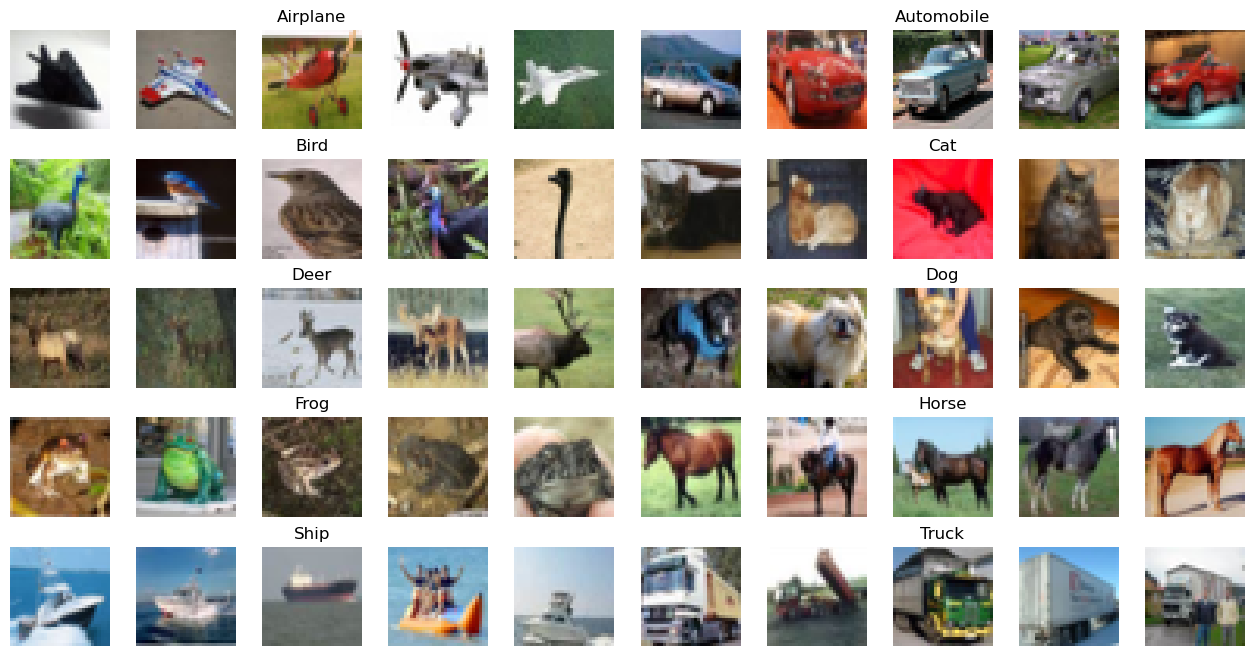

In [25]:
#observing the diversity of images

fig, axs = plt.subplots(5, 10, figsize=(16, 8))

for i, ax in enumerate(axs.flat):
    ax.imshow(X_train[first_five_indices][i])
    if i in [2,7,12,17,22,27,32,37,42,47]:
        ax.set_title(class_names[y_train[first_five_indices][i][0]])
    ax.axis("off")

fig.subplots_adjust(hspace=0.3)

plt.savefig(README_INTRO_FIG, dpi=300) 

plt.show()

# Models

#### MobileNet
- All MobileNet models share the same basic structure, consisting of the MobileNet architecture followed by pooling, a hidden layer, and a softmax output layer.
    - Transfer learning is **not** used in any of the models.
    - Unless otherwise stated, the following hyperparameters are fixed:
        - Epochs = 30, batch size = 128, and learning rate = 1E-3.
    - **[Model I](#MobileNet-Model-I)** is the baseline model as described above.
    - All subsequent models (II.1 to II.5) incorporate **L2 regularization** and **Dropout** to mitigate overfitting.
      - **[Model II.1](#MobileNet-Model-II.1)** is the baseline model with L2 regularization and Dropout added.
      - **[Model II.2](#MobileNet-Model-II.2)** uses a fixed learning rate of 1E-2 instead of 1E-3.
      - **[Model II.3](#MobileNet-Model-II.3)** employs a decaying learning rate starting at 1E-2.
      - **[Model II.4](#MobileNet-Model-II.4)** reduces the batch size to 32.
      - **[Model II.5](#MobileNet-Model-II.5)** utilizes **automated hyperparameter tuning** to optimize the model.

#### NASNetMobile
- All NASNetMobile models share the same basic structure, consisting of the NASNetMobile architecture followed by pooling, a hidden layer with **L2 regularization** and **Dropout**, and a softmax output layer.
  - Transfer learning **is used** in all models.
  - Unless otherwise stated, the base model is **not trained** (i.e., its weights are frozen).
  - The following hyperparameters are fixed:
    - Epochs = 30, batch size = 128, and learning rate = 1E-3.
  - **[Model I.1](#NASNetMobile-Model-I.1)** is the baseline model as described above.
  - **[Model I.2](#NASNetMobile-Model-I.2)** rescales the image sizes from 32x32 to 224x224, matching the input size used for ImageNet, the dataset on which the model was originally trained.
  - **[Model II](#NASNetMobile-Model-II)** allows training the base model with a learning rate of 1E-4.

## MobileNet Model I

In [ ]:
base_model = MobileNet(weights=None, include_top=False, input_shape=(32, 32, 3))

# Make sure the base model is trainable
base_model.trainable = True

model = keras.models.Sequential()

model.add(keras.layers.InputLayer(shape=(32, 32, 3)))

model.add(base_model)

model.add(keras.layers.GlobalMaxPooling2D())

model.add(keras.layers.Dense(512, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary(show_trainable=True)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ mobilenet_1.00_32 (Functional)      │ (None, 1, 1, 1024)           │     3,228,864 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_max_pooling2d_1              │ (None, 1024)                 │             0 │    -    │
│ (GlobalMaxPooling2D)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_2 (Dense)                     │ (None, 512)                  │       524,800 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_3 (Dense)                     │ (None, 10)                   │         5,130 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 3,758,794 (14.34 MB)

 Trainable params: 3,736,906 (14.26 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [ ]:
# Define your optimizer, loss, and metrics
optimizer = keras.optimizers.Adam(learning_rate=1E-3)
loss = keras.losses.SparseCategoricalCrossentropy()
metric = keras.metrics.SparseCategoricalAccuracy()

# Compile the model with accuracy
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[metric]
)


early_stop = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=1E-4,
    verbose=1,
    start_from_epoch=20
)

history = model.fit(
    X_train_mobilenet,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stop],
)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 53ms/step - loss: 2.1745 - sparse_categorical_accuracy: 0.1933 - val_loss: 2.3728 - val_sparse_categorical_accuracy: 0.0977
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1.6016 - sparse_categorical_accuracy: 0.3991 - val_loss: 2.1798 - val_sparse_categorical_accuracy: 0.1925
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 1.4216 - sparse_categorical_accuracy: 0.4747 - val_loss: 1.4669 - val_sparse_categorical_accuracy: 0.4713
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1.2663 - sparse_categorical_accuracy: 0.5459 - val_loss: 1.4804 - val_sparse_categorical_accuracy: 0.4956
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 1.1575 - sparse_categorical_accuracy: 0.5833 - val_loss: 1.4778 - val_sparse_categorical_accuracy: 0.5261
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1.0515 - sparse_categorical_accuracy: 0.6228 - val_loss: 1.4435 - val_sparse_categorical_accuracy: 0.5

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.6608 - sparse_categorical_accuracy: 0.6418


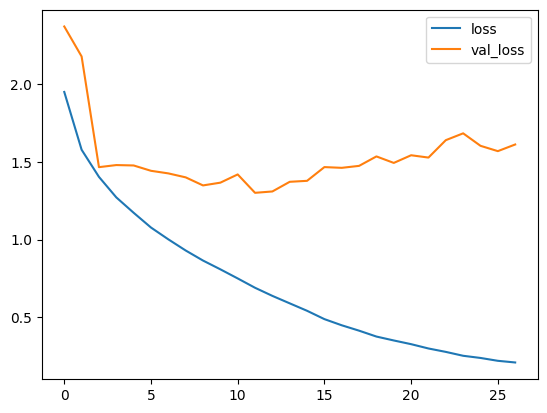

In [ ]:
model.evaluate(X_test_mobilenet, y_test)

plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()

# Save the plot to a file
plt.savefig(OVERFIT_FIG,dpi=150)

plt.show()

## MobileNet Model II.1

In [18]:
base_model = MobileNet(weights=None, include_top=False, input_shape=(32, 32, 3))

# Make sure the base model is trainable
base_model.trainable = True

model = keras.models.Sequential()

model.add(keras.layers.InputLayer(shape=(32, 32, 3)))

model.add(base_model)

model.add(keras.layers.GlobalMaxPooling2D())

model.add(keras.layers.Dense(512, activation="relu", kernel_regularizer=l2(1e-2)))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary(show_trainable=True)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ mobilenet_1.00_32 (Functional)      │ (None, 1, 1, 1024)           │     3,228,864 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_max_pooling2d_5              │ (None, 1024)                 │             0 │    -    │
│ (GlobalMaxPooling2D)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_10 (Dense)                    │ (None, 512)                  │       524,800 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_5 (Dropout)                 │ (None, 512)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_11 (Dense)                    │ (None, 10)                   │         5,130 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 3,758,794 (14.34 MB)

 Trainable params: 3,736,906 (14.26 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [19]:
# Define your optimizer, loss, and metrics
optimizer = keras.optimizers.Adam(learning_rate=1E-3)
loss = keras.losses.SparseCategoricalCrossentropy()
metric = keras.metrics.SparseCategoricalAccuracy()

# Compile the model with accuracy
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[metric]
)


early_stop = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=1E-4,
    verbose=1,
    start_from_epoch=20
)

# Define ModelCheckpoint to save the best model
checkpoint = keras.callbacks.ModelCheckpoint(
    MODELCHECKPOINT,
    monitor="val_sparse_categorical_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

history = model.fit(
    X_train_mobilenet,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint],
)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 5.1685 - sparse_categorical_accuracy: 0.1856
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.09770, saving model to best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 52ms/step - loss: 5.1625 - sparse_categorical_accuracy: 0.1858 - val_loss: 2.3694 - val_sparse_categorical_accuracy: 0.0977
Epoch 2/30
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7295 - sparse_categorical_accuracy: 0.3650
Epoch 2: val_sparse_categorical_accuracy improved from 0.09770 to 0.09880, saving model to best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.7290 - sparse_categorical_accuracy: 0.3653 - val_loss: 2.4673 - val_sparse_categorical_accuracy: 0.0988
Epoch 3/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5330 - sparse_categorical_accuracy: 0.4540
Epoch 3: val_sparse_categorical_accuracy improved from 0.09880 to 0.45040, saving model to best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss

Last Model
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.5897 - sparse_categorical_accuracy: 0.6438
Best Model
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.3962 - sparse_categorical_accuracy: 0.6473


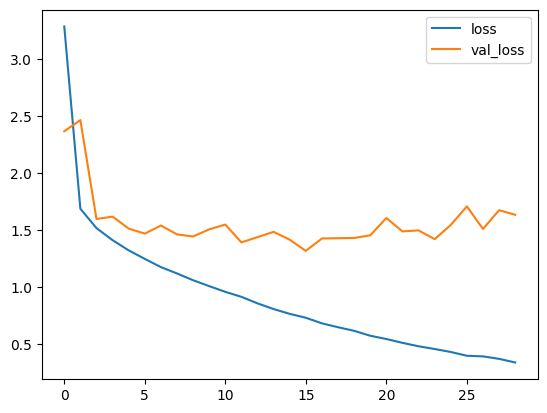

In [20]:
# Evaluate the last trained model
print('Last Model')
model.evaluate(X_test_mobilenet, y_test)
print('Best Model')
# Load the best saved model
best_model = keras.models.load_model("best_model.keras")
best_model.evaluate(X_test_mobilenet, y_test, verbose=1)

plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()

plt.show()

## MobileNet Model II.2

In [ ]:
base_model = MobileNet(weights=None, include_top=False, input_shape=(32, 32, 3))

# Make sure the base model is trainable
base_model.trainable = True

model = keras.models.Sequential()

model.add(keras.layers.InputLayer(shape=(32, 32, 3)))

model.add(base_model)

model.add(keras.layers.GlobalMaxPooling2D())

model.add(keras.layers.Dense(512, activation="relu", kernel_regularizer=l2(1e-2)))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary(show_trainable=True)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ mobilenet_1.00_32 (Functional)      │ (None, 1, 1, 1024)           │     3,228,864 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_max_pooling2d_3              │ (None, 1024)                 │             0 │    -    │
│ (GlobalMaxPooling2D)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_6 (Dense)                     │ (None, 512)                  │       524,800 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_2 (Dropout)                 │ (None, 512)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_7 (Dense)                     │ (None, 10)                   │         5,130 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 3,758,794 (14.34 MB)

 Trainable params: 3,736,906 (14.26 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [ ]:
# Define your optimizer, loss, and metrics
optimizer = keras.optimizers.Adam(learning_rate=1E-2)
loss = keras.losses.SparseCategoricalCrossentropy()
metric = keras.metrics.SparseCategoricalAccuracy()

# Compile the model with accuracy
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[metric]
)


early_stop = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=1E-4,
    verbose=1,
    start_from_epoch=20
)

history = model.fit(
    X_train_mobilenet,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stop],
)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 60ms/step - loss: 4.4690 - sparse_categorical_accuracy: 0.1816 - val_loss: 2.4079 - val_sparse_categorical_accuracy: 0.1022
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 1.6906 - sparse_categorical_accuracy: 0.3738 - val_loss: 1.6669 - val_sparse_categorical_accuracy: 0.4045
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 1.4593 - sparse_categorical_accuracy: 0.4996 - val_loss: 1.6940 - val_sparse_categorical_accuracy: 0.4820
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 1.3180 - sparse_categorical_accuracy: 0.5597 - val_loss: 2.1739 - val_sparse_categorical_accuracy: 0.4733
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 1.1932 - sparse_categorical_accuracy: 0.6097 - val_loss: 2.4694 - val_sparse_categorical_accuracy: 0.4698
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 1.0993 - sparse_categorical_accuracy: 0.6411 - val_loss: 1.5342 - val_sparse_categorical_accuracy: 0.

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.3671 - sparse_categorical_accuracy: 0.7068


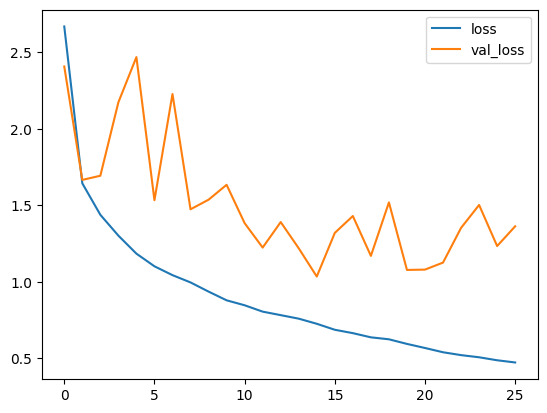

In [ ]:
model.evaluate(X_test_mobilenet, y_test)

plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()

plt.show()

## MobileNet Model II.3

In [21]:
base_model = MobileNet(weights=None, include_top=False, input_shape=(32, 32, 3))

# Make sure the base model is trainable
base_model.trainable = True

model = keras.models.Sequential()

model.add(keras.layers.InputLayer(shape=(32, 32, 3)))

model.add(base_model)

model.add(keras.layers.GlobalMaxPooling2D())

model.add(keras.layers.Dense(512, activation="relu", kernel_regularizer=l2(1e-2)))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary(show_trainable=True)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ mobilenet_1.00_32 (Functional)      │ (None, 1, 1, 1024)           │     3,228,864 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_max_pooling2d_6              │ (None, 1024)                 │             0 │    -    │
│ (GlobalMaxPooling2D)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_12 (Dense)                    │ (None, 512)                  │       524,800 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_6 (Dropout)                 │ (None, 512)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_13 (Dense)                    │ (None, 10)                   │         5,130 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 3,758,794 (14.34 MB)

 Trainable params: 3,736,906 (14.26 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [22]:
DECAY_STEPS = (((X_train_mobilenet.shape[0]*0.8)/BATCH_SIZE) * EPOCHS) * 0.55

lr_schedule = ExponentialDecay(
    initial_learning_rate=1E-2,
    decay_steps=DECAY_STEPS,  # will change the rate after 55% of the total number of steps
    decay_rate=0.9
)
y 

# Define your optimizer, loss, and metrics
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
loss = keras.losses.SparseCategoricalCrossentropy()
metric = keras.metrics.SparseCategoricalAccuracy()

# Compile the model with accuracy
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[metric]
)


early_stop = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=1E-4,
    verbose=1,
    start_from_epoch=20
)

history = model.fit(
    X_train_mobilenet,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stop],
)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 49s 62ms/step - loss: 4.1908 - sparse_categorical_accuracy: 0.1773 - val_loss: 2.5378 - val_sparse_categorical_accuracy: 0.0977
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 1.7235 - sparse_categorical_accuracy: 0.3498 - val_loss: 1.9866 - val_sparse_categorical_accuracy: 0.3314
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 1.5284 - sparse_categorical_accuracy: 0.4356 - val_loss: 1.6361 - val_sparse_categorical_accuracy: 0.4752
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 1.3938 - sparse_categorical_accuracy: 0.5078 - val_loss: 1.8589 - val_sparse_categorical_accuracy: 0.4881
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1.2596 - sparse_categorical_accuracy: 0.5770 - val_loss: 2.1148 - val_sparse_categorical_accuracy: 0.4931
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 1.1598 - sparse_categorical_accuracy: 0.6211 - val_loss: 1.8466 - val_sparse_categorical_accuracy: 0.5

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.1421 - sparse_categorical_accuracy: 0.7201


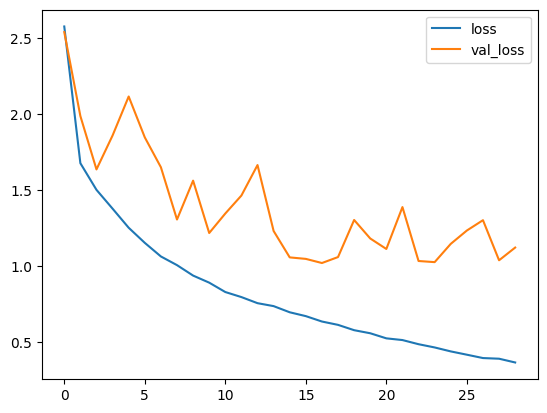

In [23]:
model.evaluate(X_test_mobilenet, y_test)

plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()

# Save the plot to a file
plt.savefig(BETTERFIT_FIG,dpi=150)

plt.show()

## MobileNet Model II.4

In [ ]:
base_model = MobileNet(weights=None, include_top=False, input_shape=(32, 32, 3))

# Make sure the base model is trainable
base_model.trainable = True

model = keras.models.Sequential()

model.add(keras.layers.InputLayer(shape=(32, 32, 3)))

model.add(base_model)

model.add(keras.layers.GlobalMaxPooling2D())

model.add(keras.layers.Dense(512, activation="relu", kernel_regularizer=l2(1e-2)))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary(show_trainable=True)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ mobilenet_1.00_32 (Functional)      │ (None, 1, 1, 1024)           │     3,228,864 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_max_pooling2d_7              │ (None, 1024)                 │             0 │    -    │
│ (GlobalMaxPooling2D)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_14 (Dense)                    │ (None, 512)                  │       524,800 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_7 (Dropout)                 │ (None, 512)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_15 (Dense)                    │ (None, 10)                   │         5,130 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 3,758,794 (14.34 MB)

 Trainable params: 3,736,906 (14.26 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [ ]:
# Define your optimizer, loss, and metrics
optimizer = keras.optimizers.Adam(learning_rate=1E-3)
loss = keras.losses.SparseCategoricalCrossentropy()
metric = keras.metrics.SparseCategoricalAccuracy()

# Compile the model with accuracy
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[metric]
)


early_stop = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=1E-4,
    verbose=1,
    start_from_epoch=20
)

history = model.fit(
    X_train_mobilenet,
    y_train,
    epochs=EPOCHS,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 15ms/step - loss: 3.8765 - sparse_categorical_accuracy: 0.1999 - val_loss: 1.7218 - val_sparse_categorical_accuracy: 0.3589
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - loss: 1.7168 - sparse_categorical_accuracy: 0.3640 - val_loss: 1.6423 - val_sparse_categorical_accuracy: 0.4099
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - loss: 1.5933 - sparse_categorical_accuracy: 0.4257 - val_loss: 1.4453 - val_sparse_categorical_accuracy: 0.4804
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 1.4933 - sparse_categorical_accuracy: 0.4887 - val_loss: 1.5381 - val_sparse_categorical_accuracy: 0.5300
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 1.3659 - sparse_categorical_accuracy: 0.5412 - val_loss: 1.4611 - val_sparse_categorical_accuracy: 0.5325
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 1.2927 - sparse_categorical_accuracy: 0.5730 - val_loss: 1.2862 - val_sparse_categoric

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.1471 - sparse_categorical_accuracy: 0.7255


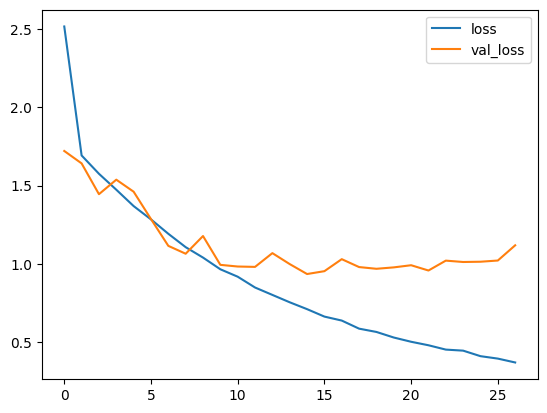

In [ ]:
model.evaluate(X_test_mobilenet, y_test)

plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()

plt.show()

## MobileNet Model II.5

In [ ]:
# Function to build the model for tuning
def build_model(hp):
    base_model = keras.applications.MobileNet(weights=None, include_top=False, input_shape=(32, 32, 3))
    base_model.trainable = True

    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(shape=(32, 32, 3)))
    model.add(base_model)
    model.add(keras.layers.GlobalMaxPooling2D())

    # Tunable hyperparameters
    units = hp.Int("units", min_value=256, max_value=896, step=128)
    dropout_rate = hp.Float("dropout", min_value=0.2, max_value=0.5, step=0.1)
    l2_reg = hp.Float("l2", min_value=1e-5, max_value=1e-2, sampling="log")

    model.add(keras.layers.Dense(units, activation="relu", kernel_regularizer=l2(l2_reg)))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(10, activation="softmax"))

    # Tunable lr_schedule hyperparameters
    initial_learning_rate = hp.Float("initial_learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    decay_steps = hp.Int("decay_steps", min_value=3000, max_value=10000, step=1000)
    decay_rate = hp.Float("decay_rate", min_value=0.60, max_value=0.96, step=0.03)

    # Learning rate schedule
    lr_schedule = ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate
    )

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()]
    )

    return model

# Initialize Keras Tuner with Bayesian Optimization
tuner = kt.BayesianOptimization(
    build_model,
    objective="val_sparse_categorical_accuracy",
    max_trials=20,
    num_initial_points=5,
    directory=KT_TUNER_DIRECTORY,
    project_name=KT_TUNER_PROJECT_NAME
)

# Split 20% of training data for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_mobilenet, y_train, test_size=0.2, random_state=42)

# Define early stopping to prevent overfitting and save time
early_stopping = EarlyStopping(
    monitor="val_loss",  # Prefer loss for better stability
    patience=3,
    restore_best_weights=True
)

# Perform hyperparameter search with early stopping
tuner.search(
    X_train_split, y_train_split,
    validation_data=(X_val_split, y_val_split),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],  # Include early stopping
    verbose=1  # Show progress
)


# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model using the found hyperparameters
best_model = tuner.hypermodel.build(best_hps)

Trial 20 Complete [00h 15m 50s]
val_sparse_categorical_accuracy: 0.6636000275611877

Best val_sparse_categorical_accuracy So Far: 0.7228999733924866
Total elapsed time: 07h 20m 58s


In [ ]:
early_stop = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=1E-4,
    verbose=1,
    start_from_epoch=20
)

# Train the best model with early stopping
history = best_model.fit(
    X_train_split,
    y_train_split,
    validation_data=(X_val_split, y_val_split),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop]
)


Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 77s 214ms/step - loss: 2.1967 - sparse_categorical_accuracy: 0.1980 - val_loss: 2.3631 - val_sparse_categorical_accuracy: 0.0994
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 64s 204ms/step - loss: 1.6660 - sparse_categorical_accuracy: 0.3734 - val_loss: 1.8834 - val_sparse_categorical_accuracy: 0.3207
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 69s 221ms/step - loss: 1.5170 - sparse_categorical_accuracy: 0.4380 - val_loss: 2.3865 - val_sparse_categorical_accuracy: 0.3963
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 65s 207ms/step - loss: 1.3960 - sparse_categorical_accuracy: 0.4994 - val_loss: 2.1404 - val_sparse_categorical_accuracy: 0.4581
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 63s 202ms/step - loss: 1.3281 - sparse_categorical_accuracy: 0.5375 - val_loss: 2.0991 - val_sparse_categorical_accuracy: 0.4468
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 64s 203ms/step - loss: 1.2616 - sparse_categorical_accuracy: 0.5559 - val_loss: 2.9803 - val_sparse_categorical_acc

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 1.1487 - sparse_categorical_accuracy: 0.7212


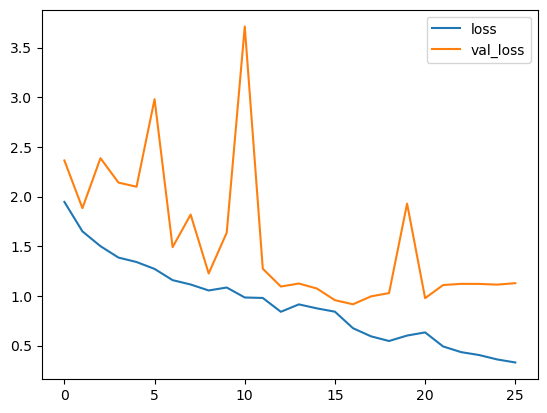

In [ ]:
best_model.evaluate(X_test_mobilenet, y_test)

#plt.plot(df_loss.index, df_loss, label="loss")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()

plt.show()

## NASNetMobile Model I

In [ ]:
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model
base_model.trainable = False

# Build the model
model = keras.models.Sequential()

# Input layer
model.add(keras.layers.InputLayer(shape=(32, 32, 3)))

# Add the pre-trained base model
model.add(base_model)
model.add(keras.layers.GlobalMaxPooling2D())

model.add(keras.layers.Dense(512, activation="relu", kernel_regularizer=l2(1e-4)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary(show_trainable=True)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ nasnet_mobile (Functional)          │ (None, 1, 1, 1056)           │     4,269,716 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_max_pooling2d_8              │ (None, 1056)                 │             0 │    -    │
│ (GlobalMaxPooling2D)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_16 (Dense)                    │ (None, 512)                  │       541,184 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_7 (Dropout)                 │ (None, 512)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_17 (Dense)                    │ (None, 10)                   │         5,130 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 4,816,030 (18.37 MB)

 Trainable params: 546,314 (2.08 MB)

 Non-trainable params: 4,269,716 (16.29 MB)

In [ ]:
# Define your optimizer, loss, and metrics
optimizer = keras.optimizers.Adam(learning_rate=1E-3)
loss = keras.losses.SparseCategoricalCrossentropy()
metric = keras.metrics.SparseCategoricalAccuracy()

# Compile the model with accuracy
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[metric]
)

early_stop = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=1E-4,
    verbose=1,
)

history = model.fit(
    X_train_nasnet,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stop],
)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 77s 144ms/step - loss: 2.2707 - sparse_categorical_accuracy: 0.3308 - val_loss: 1.5748 - val_sparse_categorical_accuracy: 0.4618
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 31ms/step - loss: 1.5755 - sparse_categorical_accuracy: 0.4654 - val_loss: 1.5286 - val_sparse_categorical_accuracy: 0.4818
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 1.5038 - sparse_categorical_accuracy: 0.4871 - val_loss: 1.5181 - val_sparse_categorical_accuracy: 0.4871
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 1.4474 - sparse_categorical_accuracy: 0.5078 - val_loss: 1.5048 - val_sparse_categorical_accuracy: 0.4929
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 1.3984 - sparse_categorical_accuracy: 0.5216 - val_loss: 1.5030 - val_sparse_categorical_accuracy: 0.4886
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 1.3771 - sparse_categorical_accuracy: 0.5337 - val_loss: 1.5145 - val_sparse_categorical_accuracy: 0

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 1.5621 - sparse_categorical_accuracy: 0.4818


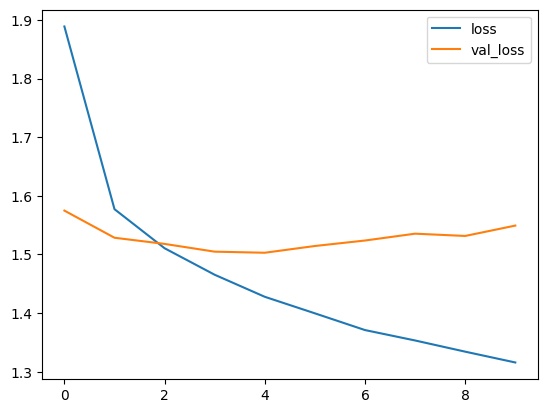

In [ ]:
model.evaluate(X_test_nasnet, y_test)

plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()

plt.show()

## NASNetMobile Model II

In [ ]:
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Build the model
model = keras.models.Sequential()

# Input layer
model.add(keras.layers.InputLayer(shape=(32, 32, 3)))
#rescaling the images to 224 x 224
model.add(keras.layers.UpSampling2D(size=(7, 7)))

# Add the pre-trained base model
model.add(base_model)
model.add(keras.layers.GlobalMaxPooling2D())

model.add(keras.layers.Dense(512, activation="relu", kernel_regularizer=l2(1e-4)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary(show_trainable=True)

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ up_sampling2d (UpSampling2D)        │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ nasnet_mobile (Functional)          │ (None, 7, 7, 1056)           │     4,269,716 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_max_pooling2d                │ (None, 1056)                 │             0 │    -    │
│ (GlobalMaxPooling2D)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 512)                  │       541,184 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 512)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_1 (Dense)                     │ (None, 10)                   │         5,130 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 4,816,030 (18.37 MB)

 Trainable params: 546,314 (2.08 MB)

 Non-trainable params: 4,269,716 (16.29 MB)

In [ ]:
# Define your optimizer, loss, and metrics
optimizer = keras.optimizers.Adam(learning_rate=1E-3)
loss = keras.losses.SparseCategoricalCrossentropy()
metric = keras.metrics.SparseCategoricalAccuracy()

# Compile the model with accuracy
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[metric]
)

early_stop = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=1E-4,
    verbose=1,
)

history = model.fit(
    X_train_nasnet,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stop],
)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 156s 344ms/step - loss: 1.6554 - sparse_categorical_accuracy: 0.6523 - val_loss: 0.6312 - val_sparse_categorical_accuracy: 0.8044
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 69s 219ms/step - loss: 0.6975 - sparse_categorical_accuracy: 0.7877 - val_loss: 0.5918 - val_sparse_categorical_accuracy: 0.8172
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 219ms/step - loss: 0.6539 - sparse_categorical_accuracy: 0.7985 - val_loss: 0.5651 - val_sparse_categorical_accuracy: 0.8275
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 218ms/step - loss: 0.6175 - sparse_categorical_accuracy: 0.8107 - val_loss: 0.5639 - val_sparse_categorical_accuracy: 0.8260
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 217ms/step - loss: 0.6033 - sparse_categorical_accuracy: 0.8149 - val_loss: 0.5435 - val_sparse_categorical_accuracy: 0.8359
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 218ms/step - loss: 0.5775 - sparse_categorical_accuracy: 0.8222 - val_loss: 0.5376 - val_sparse_categorical_ac

313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - loss: 0.5410 - sparse_categorical_accuracy: 0.8361


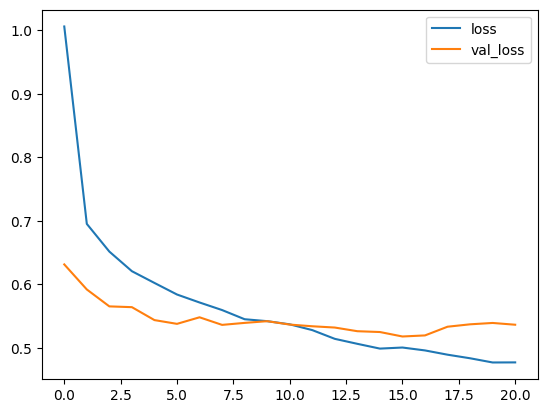

In [ ]:
model.evaluate(X_test_nasnet, y_test)

plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()

plt.show()

## NASNetMobile Model III

In [ ]:
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model
base_model.trainable = True

# Build the model
model = keras.models.Sequential()

# Input layer
model.add(keras.layers.InputLayer(shape=(32, 32, 3)))

# Add the pre-trained base model
model.add(base_model)
model.add(keras.layers.GlobalMaxPooling2D())

model.add(keras.layers.Dense(512, activation="relu", kernel_regularizer=l2(1e-4)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary(show_trainable=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ nasnet_mobile (Functional)          │ (None, 1, 1, 1056)           │     4,269,716 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_max_pooling2d_1              │ (None, 1056)                 │             0 │    -    │
│ (GlobalMaxPooling2D)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_2 (Dense)                     │ (None, 512)                  │       541,184 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_1 (Dropout)                 │ (None, 512)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_3 (Dense)                     │ (None, 10)                   │         5,130 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 4,816,030 (18.37 MB)

 Trainable params: 4,779,292 (18.23 MB)

 Non-trainable params: 36,738 (143.51 KB)

In [ ]:
# Define your optimizer, loss, and metrics
optimizer = keras.optimizers.Adam(learning_rate=1E-4)
loss = keras.losses.SparseCategoricalCrossentropy()
metric = keras.metrics.SparseCategoricalAccuracy()

# Compile the model with accuracy
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[metric]
)

early_stop = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=1E-4,
    verbose=1,
)

history = model.fit(
    X_train_nasnet,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stop],
)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 348s 427ms/step - loss: 2.4434 - sparse_categorical_accuracy: 0.2098 - val_loss: 2.5901 - val_sparse_categorical_accuracy: 0.1384
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 89ms/step - loss: 1.5369 - sparse_categorical_accuracy: 0.4741 - val_loss: 2.2703 - val_sparse_categorical_accuracy: 0.1934
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 91ms/step - loss: 1.2424 - sparse_categorical_accuracy: 0.5828 - val_loss: 2.2890 - val_sparse_categorical_accuracy: 0.1555
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - loss: 1.0777 - sparse_categorical_accuracy: 0.6463 - val_loss: 2.1720 - val_sparse_categorical_accuracy: 0.2301
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 94ms/step - loss: 0.9382 - sparse_categorical_accuracy: 0.6945 - val_loss: 2.1563 - val_sparse_categorical_accuracy: 0.2268
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - loss: 0.8191 - sparse_categorical_accuracy: 0.7342 - val_loss: 2.1932 - val_sparse_categorical_accurac

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 1.3069 - sparse_categorical_accuracy: 0.7142


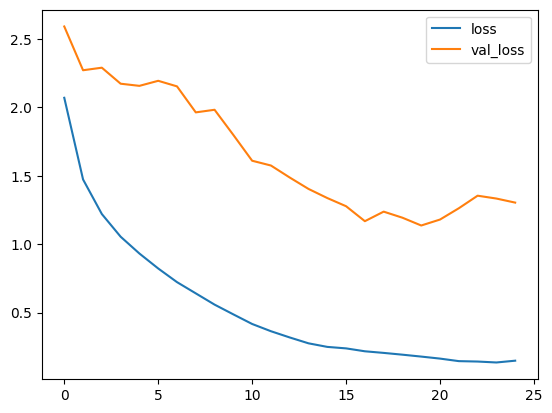

In [ ]:
model.evaluate(X_test_nasnet, y_test)

#plt.plot(df_loss.index, df_loss, label="loss")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()

plt.show()

# References
- Géron, A. (2022). Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow. " O'Reilly Media, Inc.".\
- Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press.\
- Kornblith, S., Shlens, J., & Le, Q. V. (2019). "Do better ImageNet models transfer better?" Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), 2019, pp. 2661-2671.